# Signal Processing

In this notebook we will explore methods for extracing signals from data.  This incldes computing correlation functions to tease out signals; convolution of data to model the impact of poin spread fuctions (beams in  and for use as a filter; the use of the fourier transform for filtering and for signal extraction.

## 3. Convolution

Imagine you manage a hospital treating patients with a single disease. 

You have:

- A treatment plan: [3] Every patient gets 5 units of the cure on their first day.
- A list of patient counts per day of the week: [1 2 3 4 5]

How much medicine do you use each day? 

5 $\times$  [ 1 2 3 4 5] = [5 10 15 20 25] units....easy.

You change to a more realistic treatment plan: 
- A treatment plan: [5 3 1] Every patient gets 5 units of the cure on their first day, 3 their second, 1 their third.

We can do this, but it gets harder. 

The trick is to flip the treatment plan to [1 3 5]  and walk the treatment schedule backwards through the patients. Here's the view:

Monday

    1  3  5                  
          *
         [1  2  3  4  5] 
    
         =5           
            
Tuesday

      1  3  5       
         *  *
        [1  2  3  4  5]
    
         3 +10 = 13
              

Wednesday
 
          1  3  5 
          *  *  *
         [1  2  3  4  5]
    
          1 + 6 + 15 = 22
             
Thursday

             1  3  5
             *  *  *
         [1  2  3  4  5]
    
             2+ 9 +20 = 31
        
Friday

                1  3  5
                *  *  *
         [1  2  3  4  5]
       
                3 +12+25 = 40            

And we have to finish the treatments of the patients who came in later in the week:

Saturday

                   1  3  5
                   *  *
         [1  2  3  4  5]
    
                   4 + 15 = 19
      
Sunday

                      1  3  5
                      *
         [1  2  3  4  5]
    
                      = 5

Which leaves us with the following requirements for our treatment units:
[5 13 22 31 40 19 5]

This calculation is the convolution of the plan and patient counrs.


### the definition
When discussing signal processing, you will often see convolution expressed as:

$$(f \star g)(\tau) = \int_{-\infty}^\infty f(t) g(\tau -t) dt \tag{13}$$
$$(g \star f)(\tau) = \int_{-\infty}^\infty f(\tau -t) g(t) dt$$

Note the new symbol $\star$ representing the operation and note that one of functions is <i> reversed </i>. We speak of $f$ being the source and $g$ being the filter of the convolution.


### properties 
Some useful properties of the convolution include:

- It is commutative
- It integrates as seperable functions: $$\int f \star g = \int f \int g$$
- $\displaystyle{f(t) * \delta(t) = f(t)}$
- $\displaystyle{f(t) * \delta(t - T) = f(t - T)}$


### example

The <a href="https://en.wikipedia.org/wiki/Convolution">convolution</a> of two discretely sampled (with $N$ samples) functions $f_i$ and $g_i$ is defined as $$(f * g)_k = \sum_{i=0}^{N-1} f_k g_{i-k} \tag{12}$$.

In other words, to calcuate the convolution: (1) multiply two functions and sum them to get a number and (2) repeat the procedure for all possible offsets.

We next compute the convolution of a gaussian or $\chi^2$ with two delta functions using equation 12:

In [236]:
import numpy as np
import matplotlib.pyplot as plt

In [237]:
def convolution(f,g):
    g=g[::-1]
    N = np.size(f)
    conv = np.zeros(N)
    i = 0
    while (i <N):
        conv[i] = np.sum(f *np.roll(g,i))
        i+=1
    return(conv)


In [238]:
#Import a chi2 library from stats
from scipy.stats import chi2
N = 512
t = np.arange(1,N+1)/N ## n/N becomes time, a variable from 0 to 1. Note that it is COMPLEX


#Create the two delta functions over the 1024 space used earlier.
f = np.zeros(N)
f[int(N*1/6)] = 1.
f[int(N*5/6)] = 1.


## create a function to convolve with our delta funcitons.
gauss=True

if chi2:    
    g = chi2.pdf(np.real(t), 55)
    g = g/np.max(g)
if gauss:
    g = np.exp(-5 * ((t-np.mean(t))/.1)**2.)

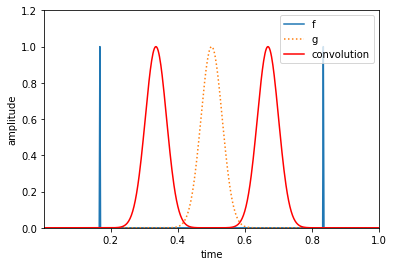

In [239]:
#run the convolution
conv = convolution(f,g)
#plot the results
plt.plot(t,f, label='f')
plt.plot(t,g, ':', label='g')
plt.plot(t,conv,"r", label='convolution')
plt.legend(loc='best')
plt.axis([np.min(t),np.max(t),0,1.2])

plt.xlabel("time")
plt.ylabel("amplitude")
#pl.title("f (blue), g(green), and the convolution of these (red)")
plt.show()

Notice that the convolved delta functions are not at the correct location. This is because the lag ($\tau$ in the formula or $i$ in the code) walks forward from where it starts (see above example). So our lags have a <i> shift </i> that we must account for, which in this case is N/2 What's tne solution? We <i>roll</i> $t$ forward by this amount:

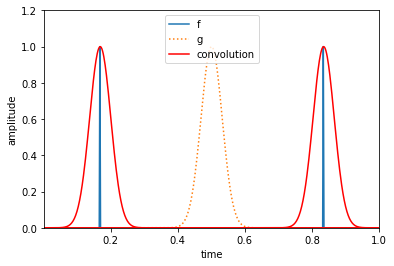

In [240]:
#run the convolution
conv = convolution(f,g)
#plot the results
plt.plot(t,f, label='f')
plt.plot(t,g, ':', label='g')
plt.plot(np.roll(t,int(N/2)),conv,"r", label='convolution')
plt.legend(loc='best')
plt.axis([np.min(t),np.max(t),0,1.2])

plt.xlabel("time")
plt.ylabel("amplitude")
#pl.title("f (blue), g(green), and the convolution of these (red)")
plt.show()

We can also just remove this shift if we change our "filter" ($g(t)$) to be centered on the origin. In many cases, it is best to just keep things centered at the origin if possible, especially the filter inside a convolution.

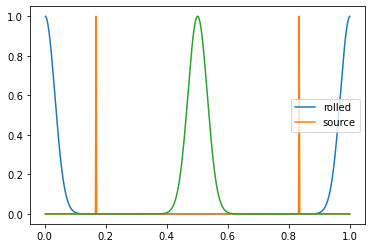

In [241]:
plt.plot(t,(np.roll(g,int(N/2))),label='rolled')
plt.plot(t,f, label='source')
plt.legend()
plt.plot(t,g)

In [242]:
# Roll the function g by the Nyquist frequency to shift it
conv_shift = convolution(f,np.roll(g,int(N/2)))

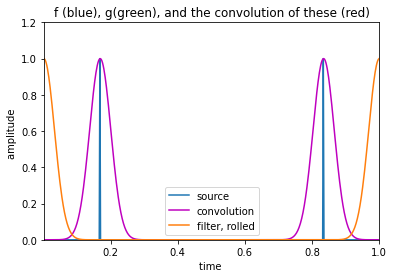

In [243]:
#plot it
plt.plot(t,f, label='source')
plt.plot(t,conv_shift,"m", label='convolution')
plt.plot(t,np.roll(g,int(N/2)),label='filter, rolled')
plt.legend(loc='best')
plt.axis([np.min(t),np.max(t),0,1.2])

plt.xlabel("time ")
plt.ylabel("amplitude ")
plt.title("f (blue), g(green), and the convolution of these (red)")
plt.show()